# EDA for EIA Data

## Load in libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import pickle
import re

In [2]:
demand_df = pd.read_parquet('../data/energy_demand.parquet')
weather_df = pd.read_parquet('../data/weather.parquet')
XLE_df = pd.read_csv('../data/XLE.csv')
holidays = pd.read_csv('../data/holiday.csv')

In [3]:
demand_df['respondent-name'] = demand_df['respondent-name'].replace('Florida', 'Florida Power and Light')

In [4]:
demand_df['period'] = pd.to_datetime(demand_df.period)

# Cleaning and Mergin DataFrames
We create a column called 'name' which is a duplicate of respondent-name and then replace the names with the city names. We will us the
name column to merge our weather data which has the city names.

In [5]:
demand_df['name'] = demand_df['respondent-name']
demand_df['name'].value_counts()

name
California Independent System Operator         68872
New York Independent System Operator           68866
Florida Power and Light                        68862
Electric Reliability Council of Texas, Inc.    68817
Name: count, dtype: int64

In [6]:
respondents =['Electric Reliability Council of Texas, Inc.' ,
              'New York Independent System Operator',
              'Florida Power and Light' ,
               'California Independent System Operator',]

In [7]:
demand_df['name'] = demand_df['name'].replace(respondents[3], 'Los Angeles')
demand_df['name'] = demand_df['name'].replace(respondents[2], 'Tampa')
demand_df['name'] = demand_df['name'].replace(respondents[0], 'Austin')
demand_df['name'] = demand_df['name'].replace(respondents[1], 'new york city')

In [8]:
energy_df = pd.merge(demand_df, weather_df, how='inner', on=['name', 'period'], suffixes=('', '2'))

## Merging XLE
XLE is a index fund that tracks the energy sector. We will use this data to represent the state of enery prices. The data was source
from [yahoo finance](https://finance.yahoo.com/quote/XLE?p=XLE&.tsrc=fin-srch). We used the adjusted close which is the closing price
at 4pm est adjust for dividends and share splits.

Since the data is daily we will join on the year and day of year. We will also create a 30 day and 60 day lag period. We believe this
will be helpful to the model because not everyone adjusts their energy consumption immediately and the lags could add to the model
performance.


In [9]:
XLE_df = XLE_df.set_index('Date')
XLE_df.index = pd.to_datetime(XLE_df.index, utc=True)
XLE_df = XLE_df[['Adj Close']].copy()
XLE_df['year'] = XLE_df.index.year
XLE_df['dayofyear'] = XLE_df.index.dayofyear

In [10]:
XLE_df.sort_index(inplace=True)

In [11]:
XLE_df['Adj_Close_30D_lag'] = XLE_df['Adj Close'].shift(freq='28D')
XLE_df['Adj_Close_60D_lag'] = XLE_df['Adj Close'].shift(freq='56D')
XLE_df['Adj_Close_3D_lag'] = XLE_df['Adj Close'].shift(freq='4D')
energy_df = pd.merge(energy_df,XLE_df,how='left', on=['year','dayofyear'])

## Merging Holidays

We merge holdiays on year and day of year.

In [12]:
holidays =holidays.drop('Date',axis=1)
energy_df = pd.merge(energy_df,holidays, how='left', on=['year','dayofyear'])

## Check for nulls
We have some nulls in the dataframe. Since this is time series data we will use a backfill to fill null values.
Backfilling helps us keep more data and also smoothes out the data beacuse we will have less gaps in time.

Backfilling makes sense here because we are using weather data. If the temperature yesterday was 70 degrees
then it is most likly the following day will be 70 degrees or close to it.

In [13]:
energy_df.isna().sum();
energy_df = energy_df.sort_values(['respondent','period'])

In [14]:
energy_df['value'] = energy_df['value'].ffill()
energy_df['solarradiation'] = energy_df['solarradiation'].ffill()
energy_df['uvindex'] = energy_df['uvindex'].ffill()
energy_df['snow'] = energy_df['snow'].ffill()
energy_df['Adj Close'] = energy_df['Adj Close'].ffill()
energy_df['Adj_Close_30D_lag'] = energy_df['Adj_Close_30D_lag'].ffill()
energy_df['Adj_Close_60D_lag'] = energy_df['Adj_Close_60D_lag'].ffill()
energy_df['Adj_Close_3D_lag'] = energy_df['Adj_Close_3D_lag'].ffill()

## Set the index to period and conver to a datetime

In [15]:
energy_df = energy_df.set_index('period')
energy_df.index = pd.to_datetime(energy_df.index)

## Create a weekend feature

In [16]:
energy_df["Is Weekend"] = energy_df.index.day_name().isin(['Saturday', 'Sunday'])

In [17]:
energy_df.columns;

In [18]:
columns = ['respondent-name','value',
        'year', 'month', 'days', 'hour', 'quarter', 'dayofyear',
        'temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'snow', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'uvindex', 'conditions',
       'icon', 'Adj_Close_30D_lag', 'Adj_Close_60D_lag', 'Holiday','Is Weekend', 'Adj_Close_3D_lag']

In [19]:
energy_df = energy_df[columns].copy()

## Drop redundant columns

In [20]:
energy_df = energy_df.drop(['conditions','icon'], axis=1)

## Create dummy variables

In [21]:
energy_df.rename(columns={'respondent-name':'respondent',}, inplace=True)
energy_df = pd.get_dummies(energy_df, columns=['Holiday','Is Weekend'], drop_first=True, dtype=float)

## Fixing column names
LGBM will throw an error if there are any special characters in the column names. The follwing code will
remove those characters and rename the columns

In [22]:
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in energy_df.columns}
new_n_list = list(new_names.values())
# [LightGBM] Feature appears more than one time.
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
energy_df = energy_df.rename(columns=new_names)

## Checking Outliers

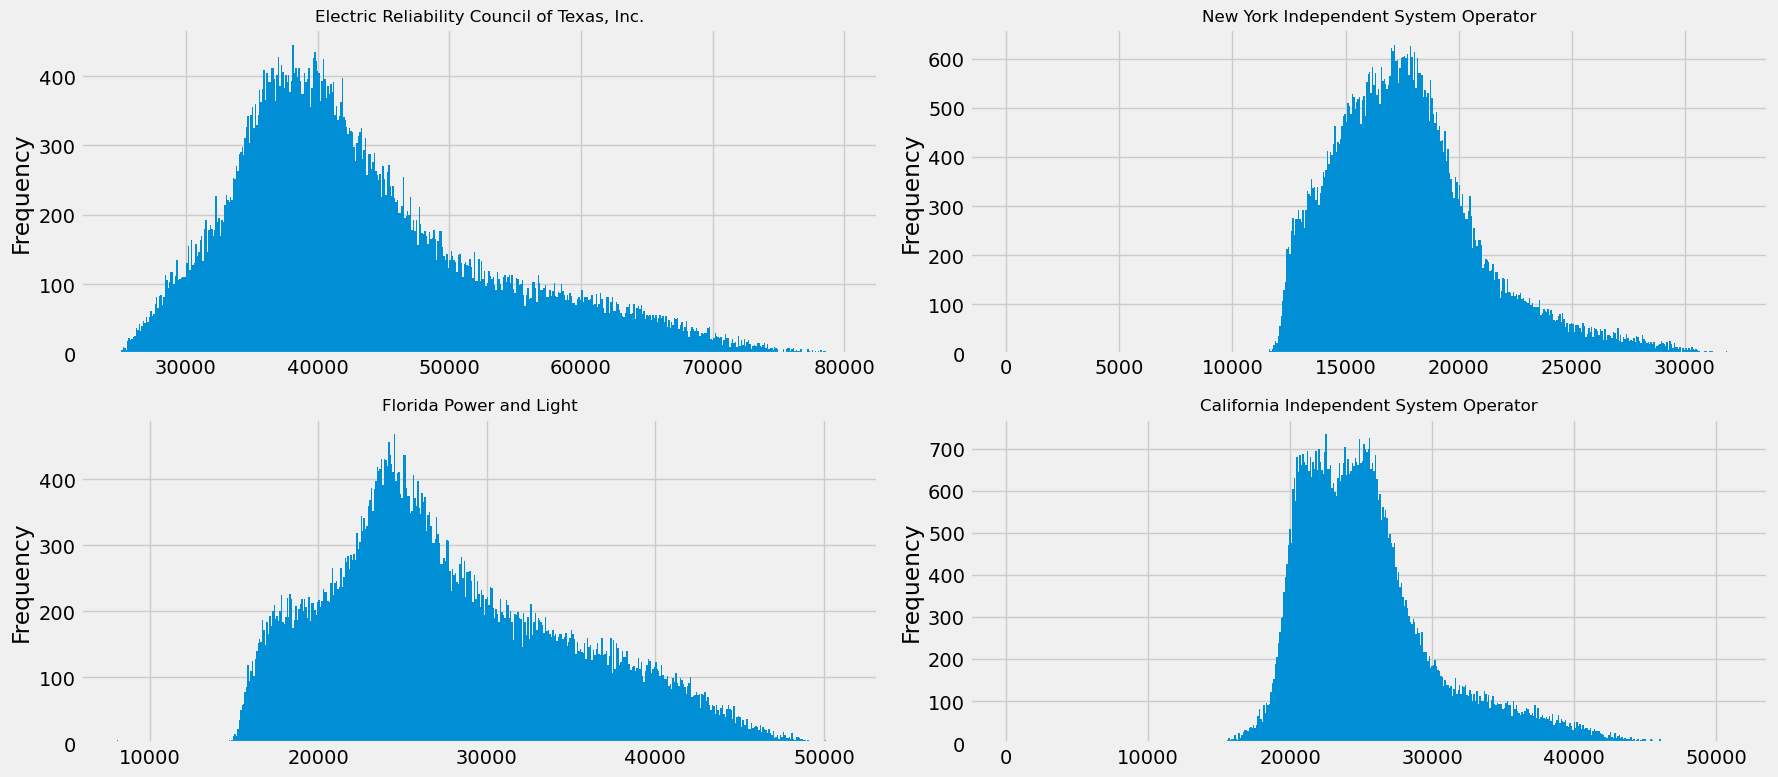

In [23]:
for n,res in enumerate(respondents):
    ax = plt.subplot(2,2,n+1)
    energy_df.query(f"respondent == '{res}' ")['value'].plot(kind='hist', bins =500,ax =ax, figsize=(18,8))
    ax.set_title(label =f'{res}',fontsize =12)
    plt.tight_layout()

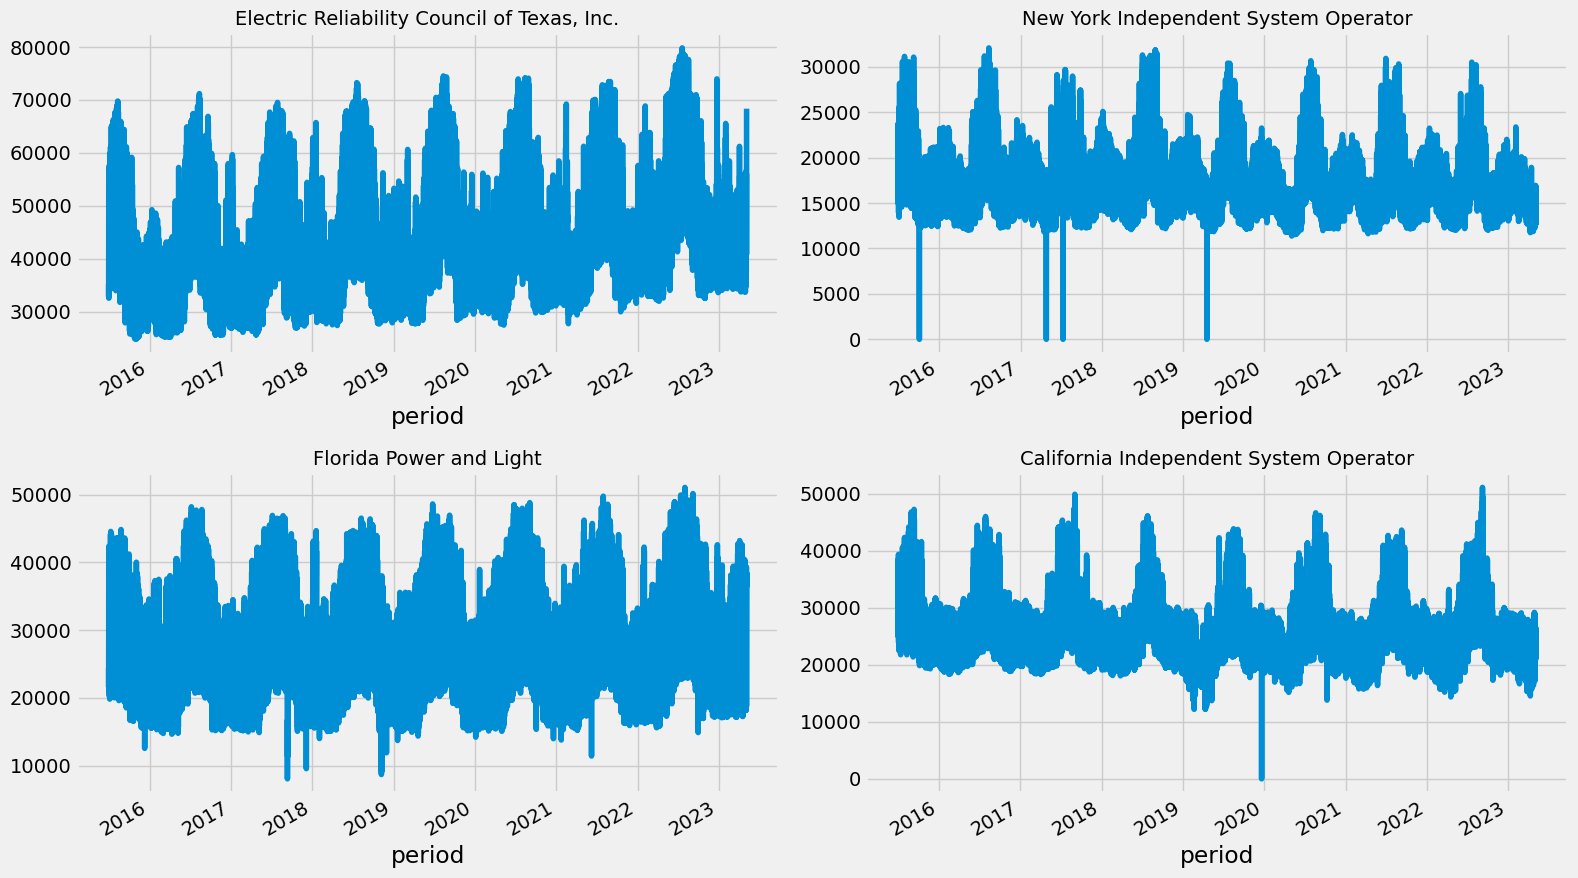

In [24]:
for n,res in enumerate(respondents):
    ax = plt.subplot(2,2,n+1)
    energy_df.query(f"respondent == '{res}' ")['value'].plot(ax =ax, figsize=(16,9))
    ax.set_title(label =f'{res}',fontsize =14)
    plt.tight_layout()

## Filter Outliers
We have identified the outliers in our plot and filtering our data. We also seperate our States in preperation
for a ml model. After the States are seperated we add 2 more features.
The first line below will create another lag that looks at the demand 72 hours prior. The second line will
create a forecasted feature were we are lookin at the temperature tomorrow.
```
NY['demand_3d_lag'] = NY['value'].shift(72)
NY['24_hours_ahead'] = NY['temp'].shift(-24)
```

In [25]:
NY = energy_df.query("respondent== 'New York Independent System Operator' and value > 11000 and value <32000").copy()
FL = energy_df.query("respondent == 'Florida Power and Light' and value >14000 and value < 49000").copy()
CA = energy_df.query("respondent ==  'California Independent System Operator' and value >15000 and value <46000").copy()
TX = energy_df.query("respondent ==  'Electric Reliability Council of Texas, Inc.' and value <75000 ").copy()

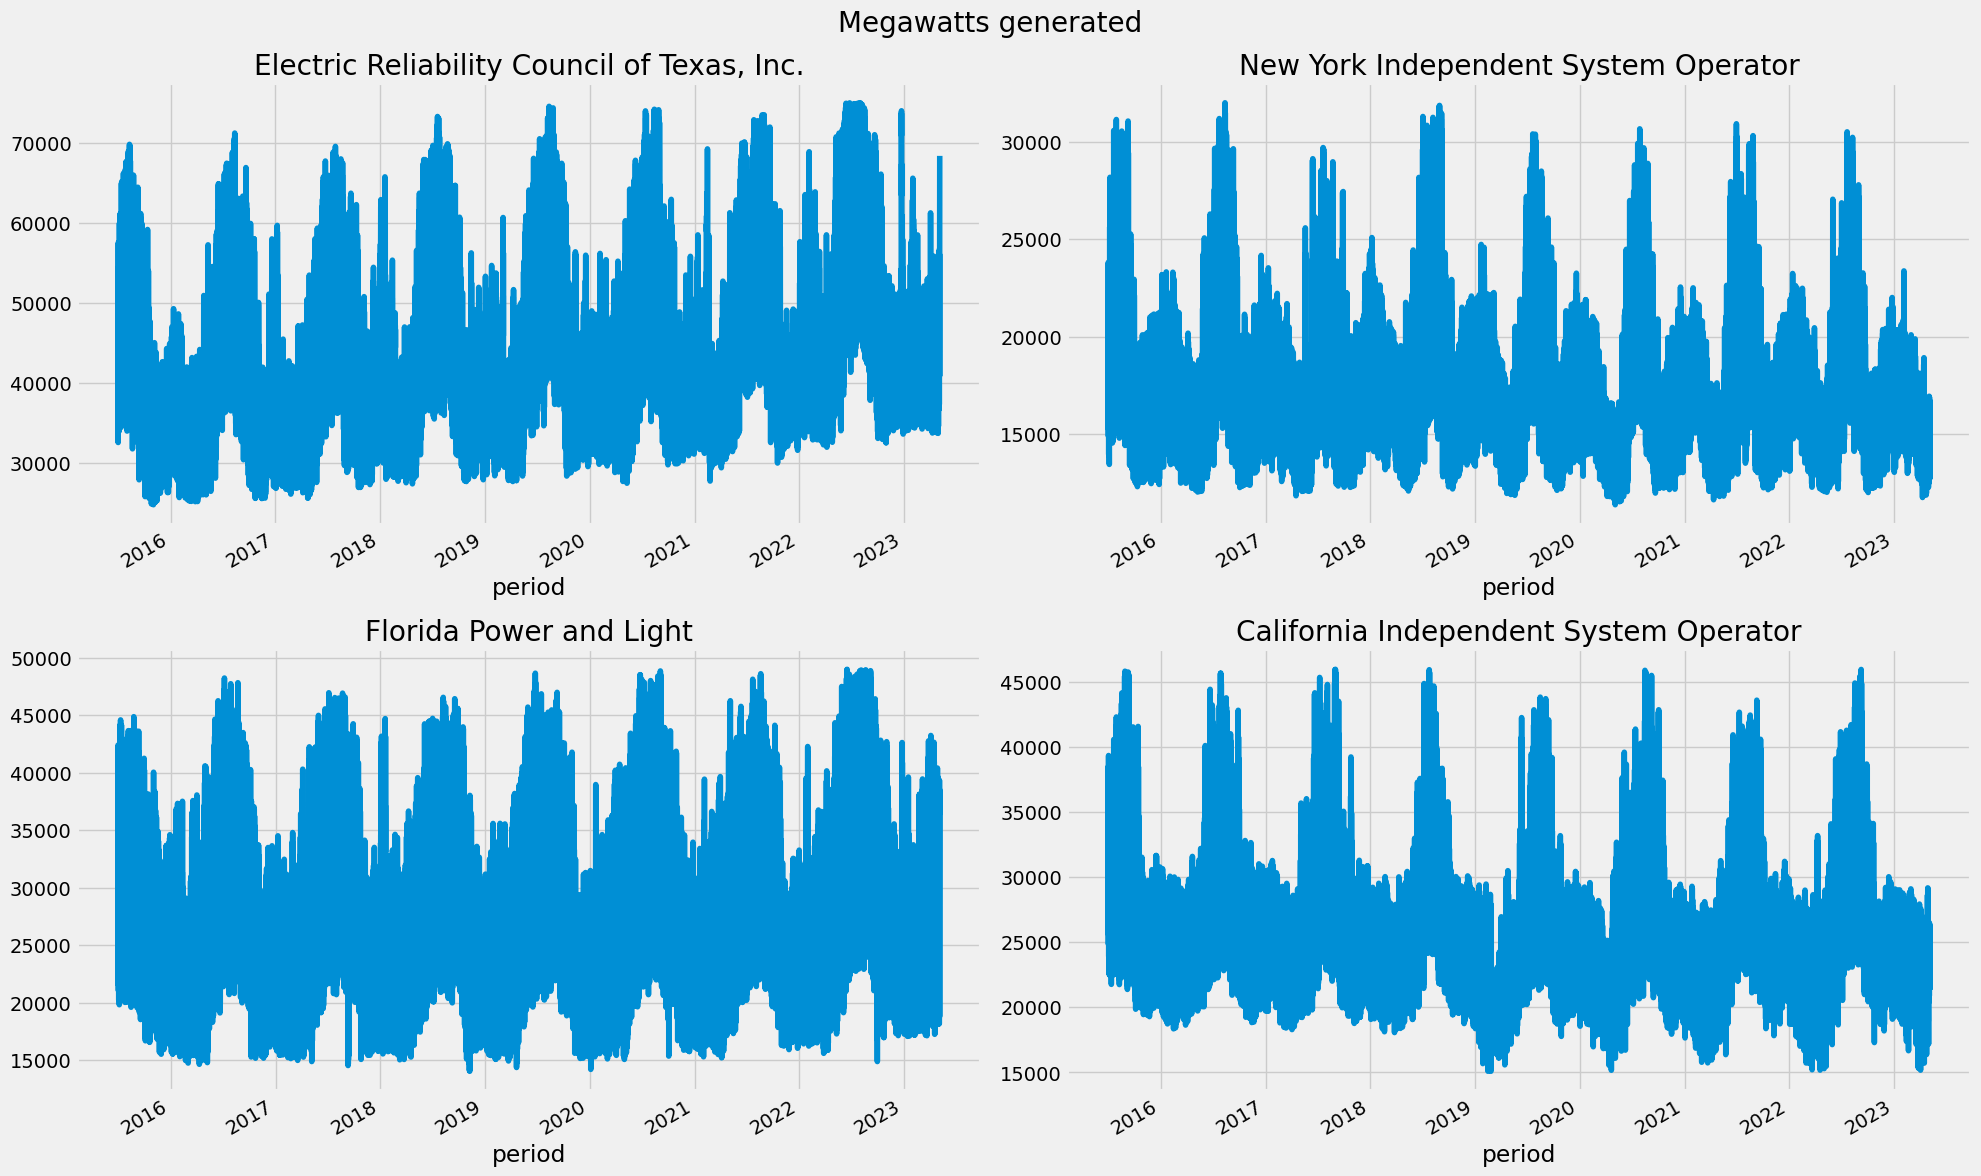

In [26]:
fig, ax = plt.subplots(2,2,figsize=(20,12))
TX['value'].plot(ax=ax[0, 0], title =respondents[0])
NY['value'].plot(ax=ax[0, 1], title = respondents[1])
FL['value'].plot(ax=ax[1, 0], title =respondents[2])
CA['value'].plot(ax=ax[1, 1], title =respondents[3])
fig.suptitle("Megawatts generated", fontsize=20)
plt.tight_layout(pad=1)
plt.show()

In [27]:
TX = TX[~TX.index.duplicated(keep='first')]
NY = NY[~NY.index.duplicated(keep='first')]
CA = CA[~CA.index.duplicated(keep='first')]
FL = FL[~FL.index.duplicated(keep='first')]

In [28]:
NY['demand_3d_lag'] = NY['value'].shift(72, freq='h')
FL['demand_3d_lag'] = FL['value'].shift(72, freq='h')
CA['demand_3d_lag'] = CA['value'].shift(72, freq='h')
TX['demand_3d_lag'] = TX['value'].shift(72, freq='h')

In [29]:
NY['Temp_24_hours_ahead'] = NY['temp'].shift(-24, freq='h')
FL['Temp_24_hours_ahead'] = FL['temp'].shift(-24 ,freq='h')
CA['Temp_24_hours_ahead'] = CA['temp'].shift(-24, freq='h')
TX['Temp_24_hours_ahead'] = TX['temp'].shift(-24, freq='h')

In [30]:
NY.dropna(inplace=True)
FL.dropna(inplace=True)
CA.dropna(inplace=True)
TX.dropna(inplace=True)

In [31]:
def create_box_plot(frequency= 'month'):
    """ This function graphs demand based on the frequency.
    Frequency default is 'month'. Other options are
    year, hour, dayofweek, quarter and dayofyear"""
    frequency= frequency.lower()
    fig, ax = plt.subplots(2,2 ,figsize=(20,12))
    sns.boxplot(data=TX, x=frequency, y='value', palette='Blues', ax=ax[0, 0], width=.4, linewidth=.8, fliersize=4)
    ax[0,0].set_title(respondents[0])
    sns.boxplot(data=NY, x=frequency, y='value', palette='Blues', ax=ax[0, 1], width=.4, linewidth=.8, fliersize=4)
    ax[0,1].set_title(respondents[1])
    sns.boxplot(data=FL, x=frequency, y='value', palette='Blues', ax=ax[1, 0], width=.4, linewidth=.8, fliersize=4)
    ax[1,0].set_title(respondents[2])
    sns.boxplot(data=CA, x=frequency, y='value', palette='Blues', ax=ax[1, 1], width=.4, linewidth=.8, fliersize=4)
    ax[1,1].set_title(respondents[3])
    plt.tight_layout(pad=2)
    plt.show()

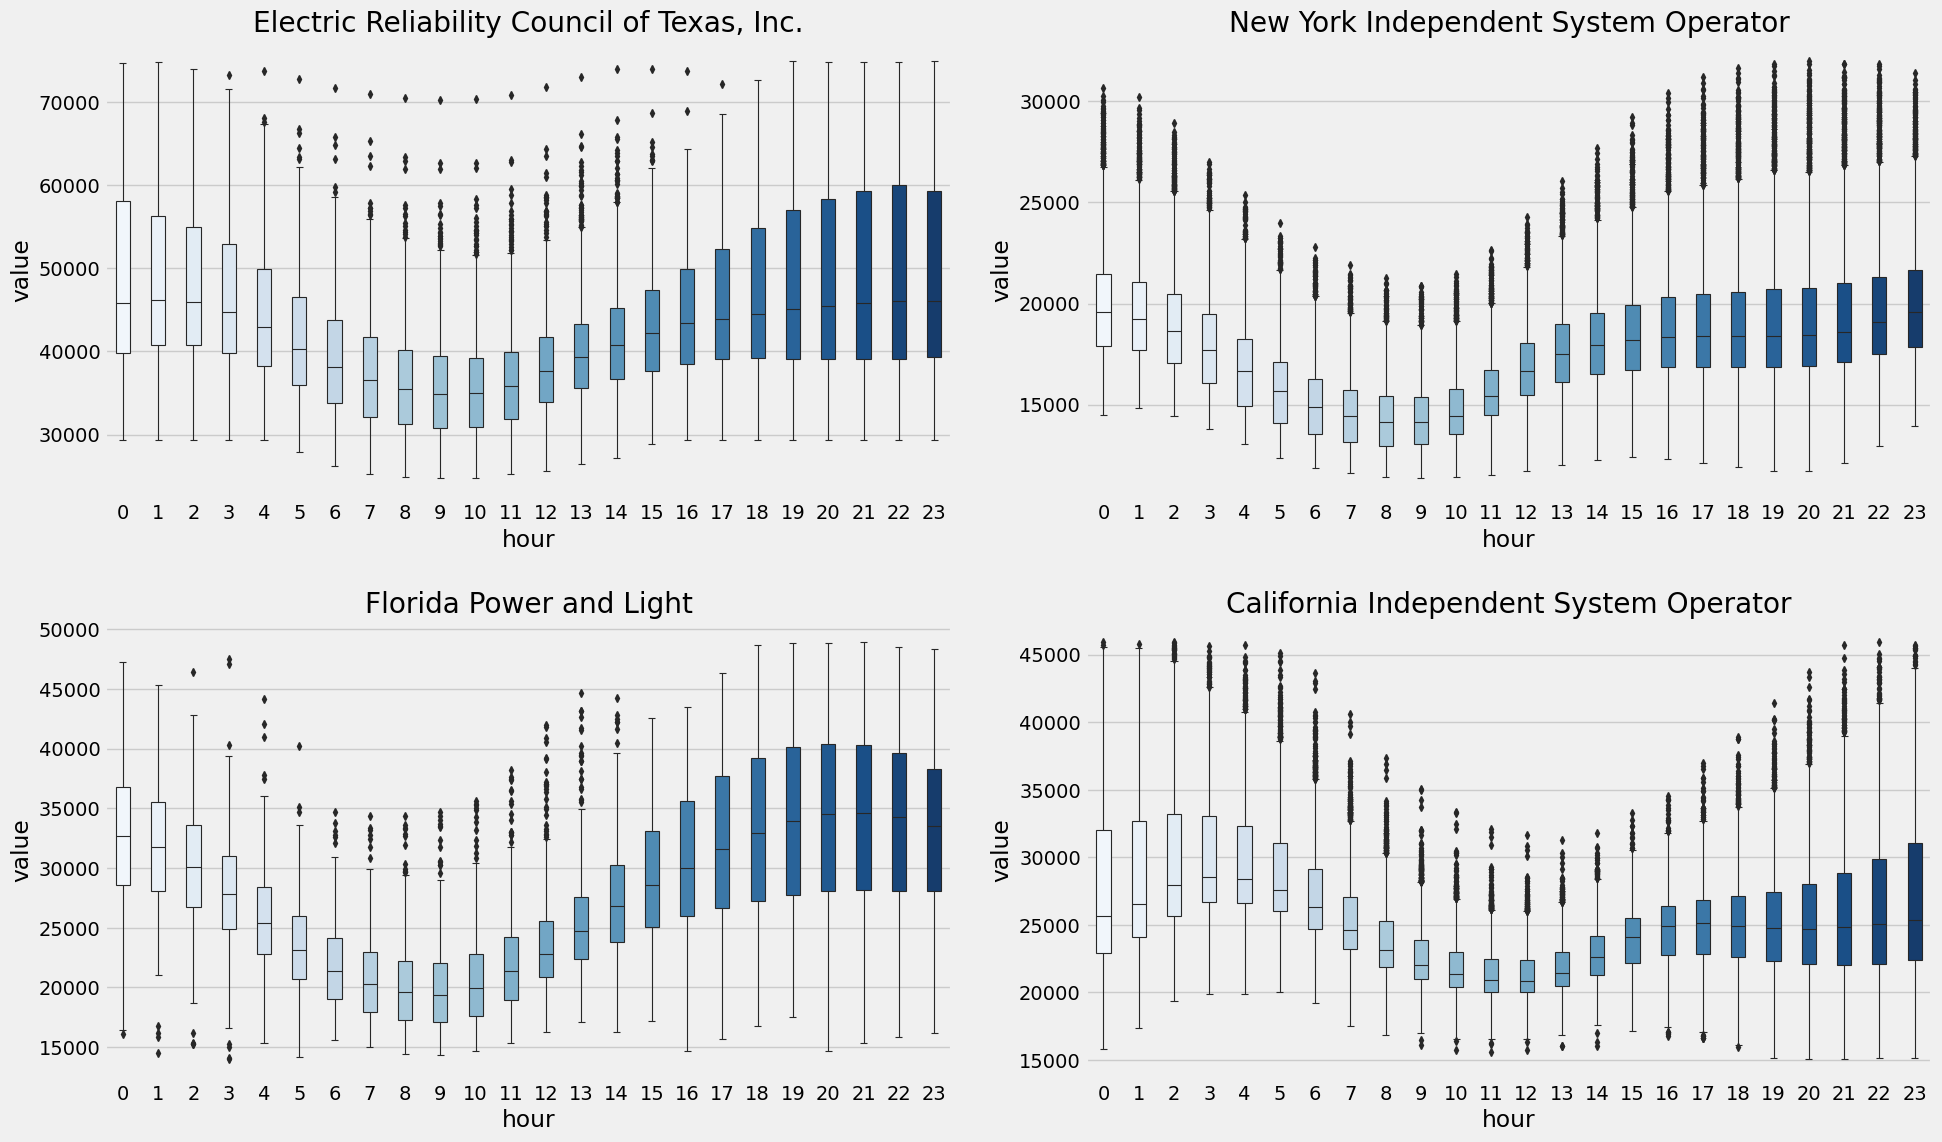

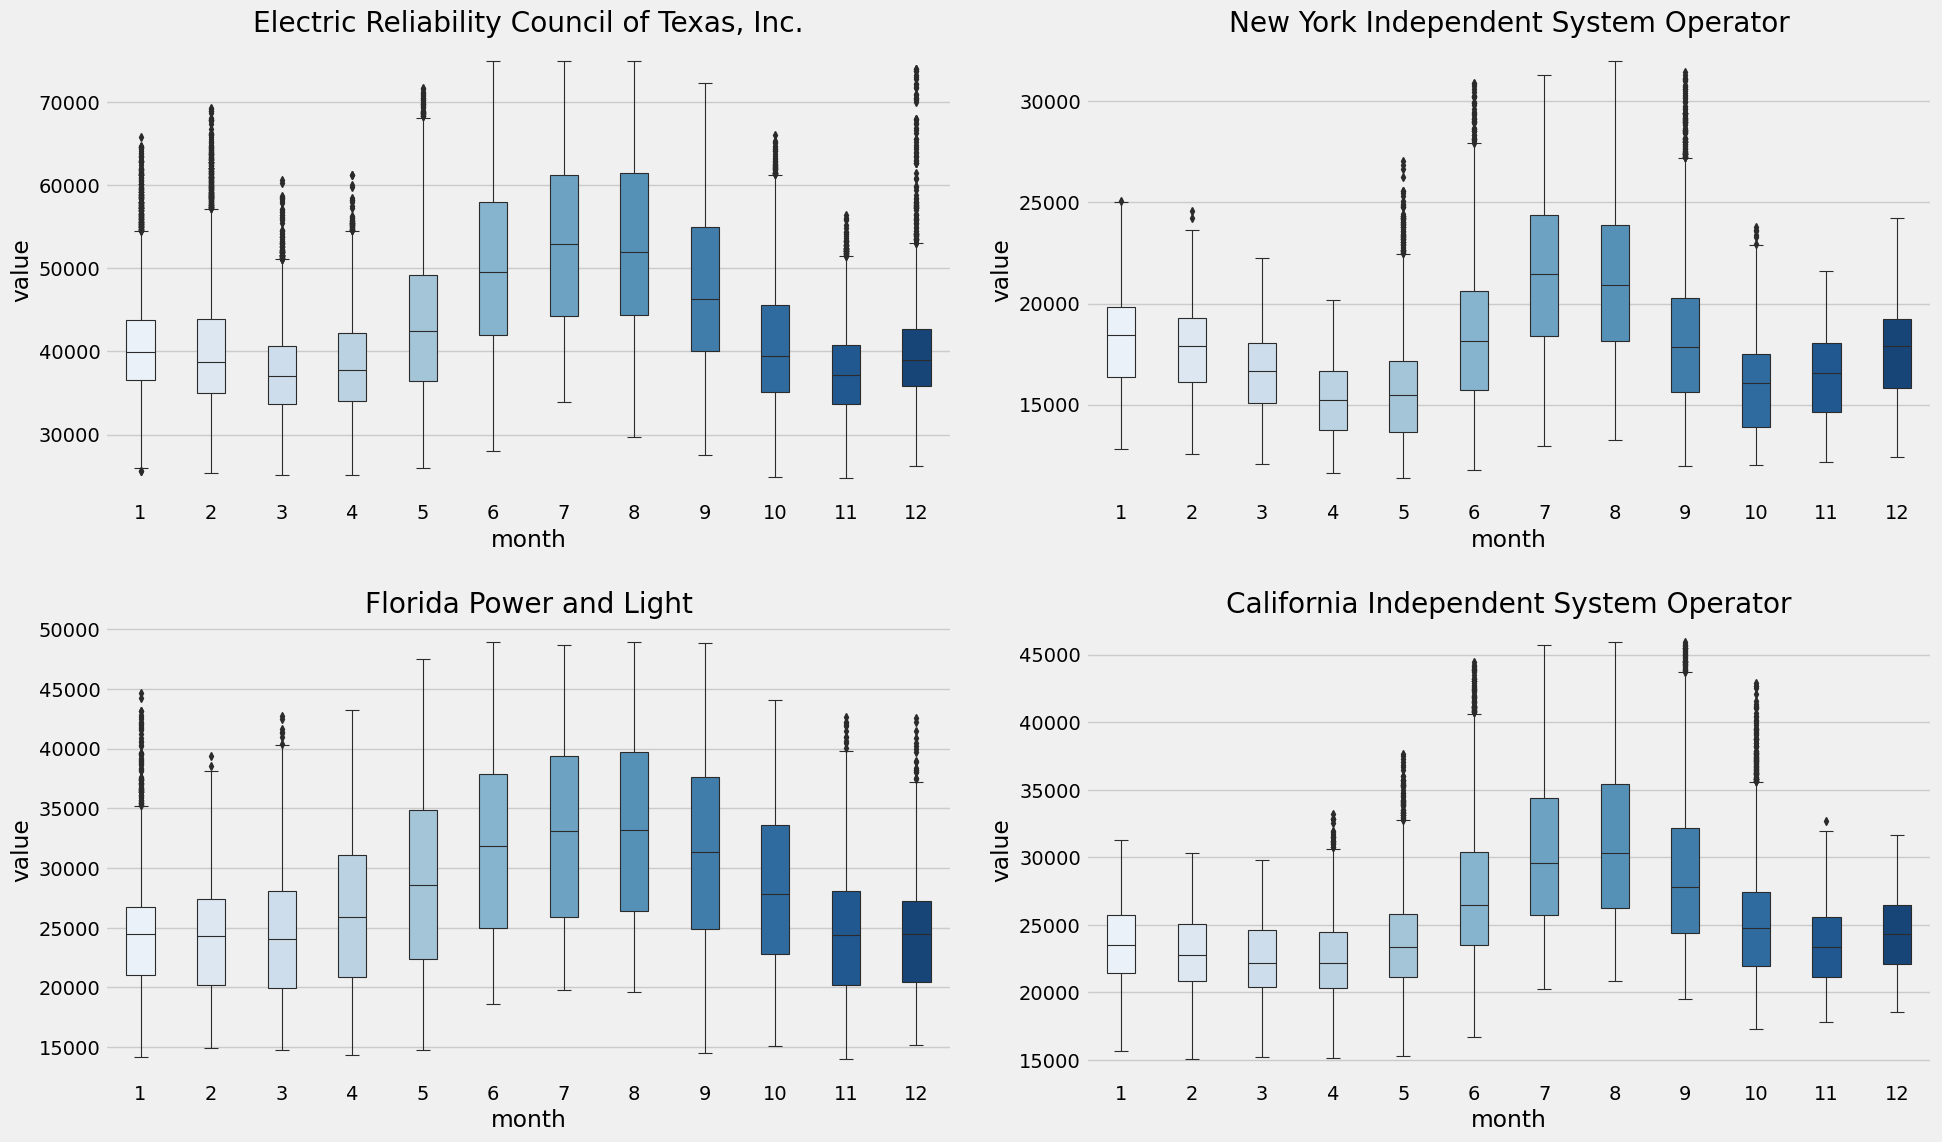

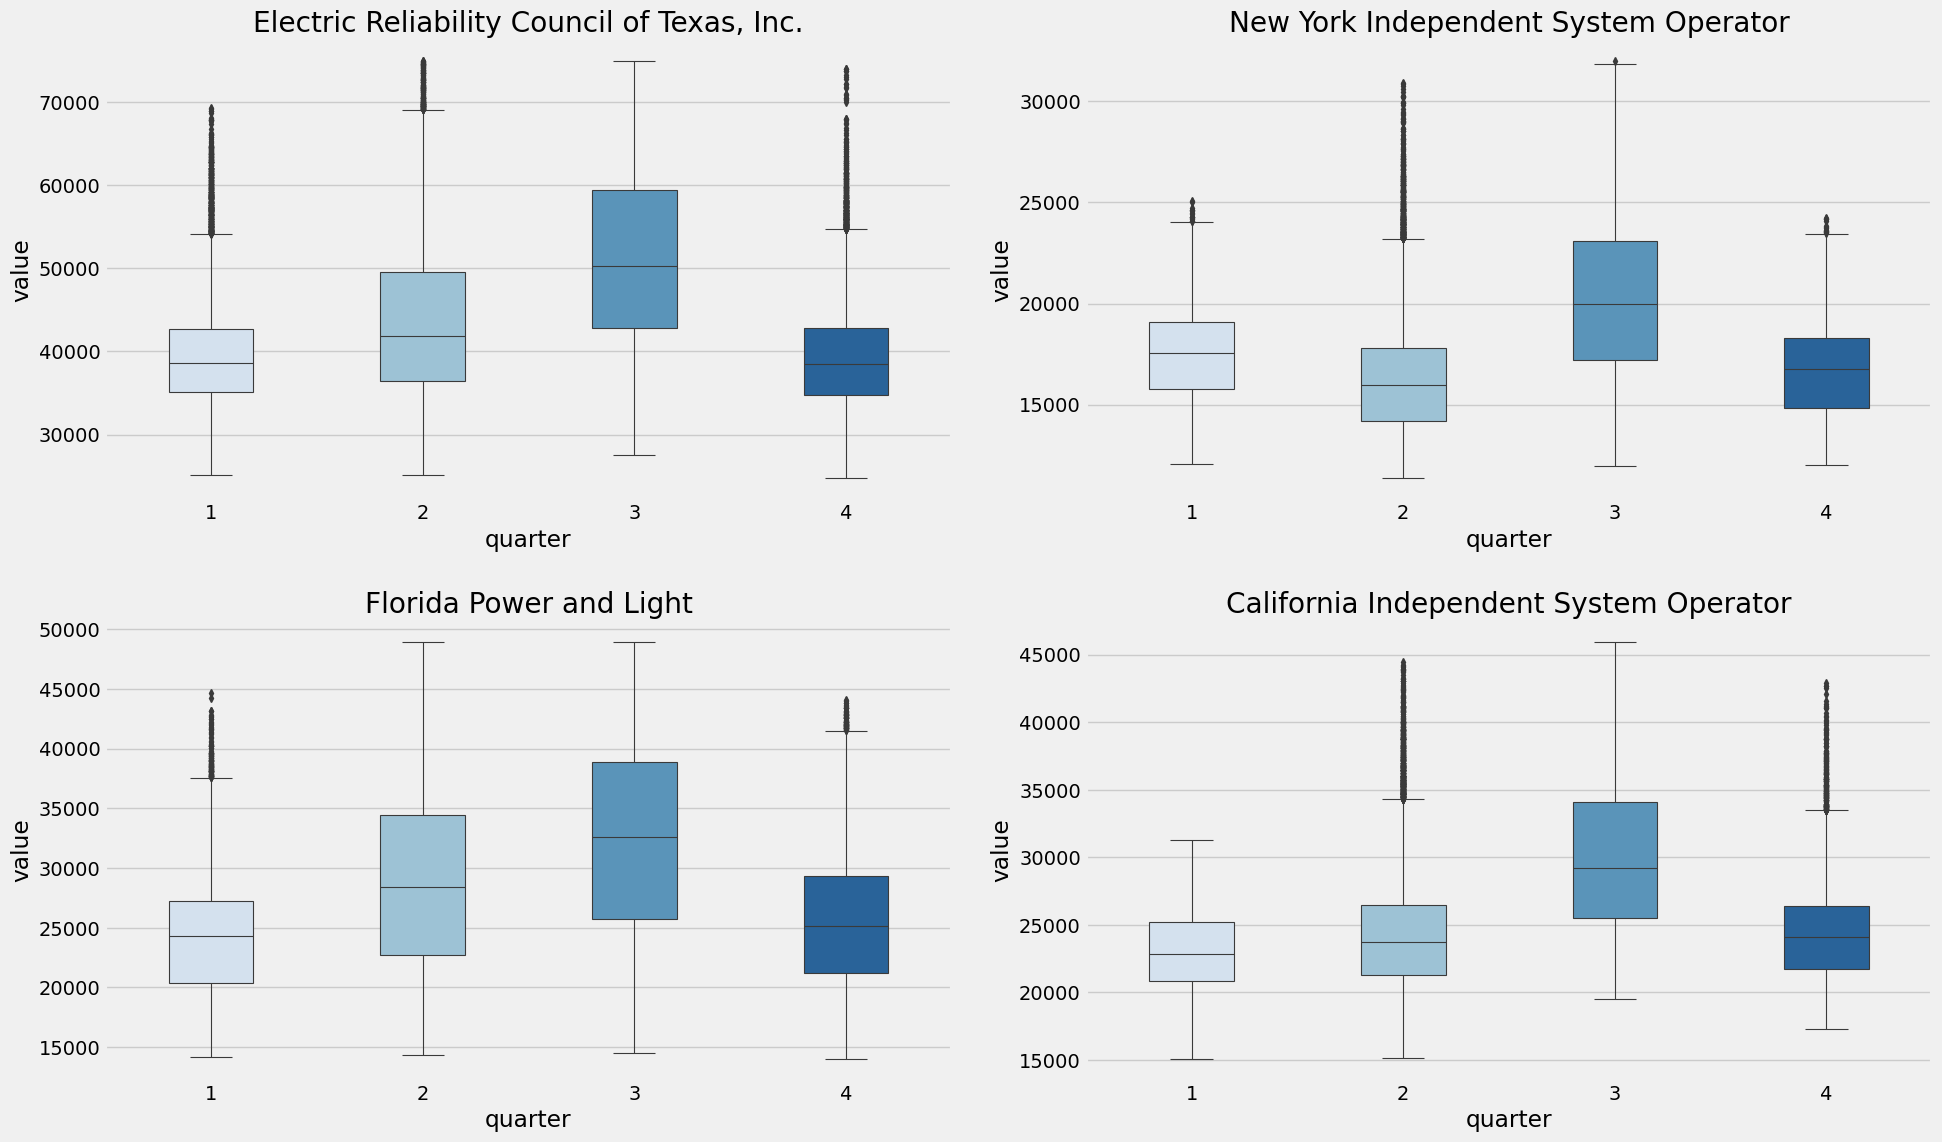

In [32]:
hour = create_box_plot('hour')
month = create_box_plot('month')
quarter = create_box_plot('quarter')

In [33]:
# NY.to_parquet('../data/ML_Data/NY', engine='pyarrow')
# FL.to_parquet('../data/ML_Data/FL', engine='pyarrow')
# CA.to_parquet('../data/ML_Data/CA', engine='pyarrow')
# TX.to_parquet('../data/ML_Data/TX', engine='pyarrow')